<AxesSubplot: >

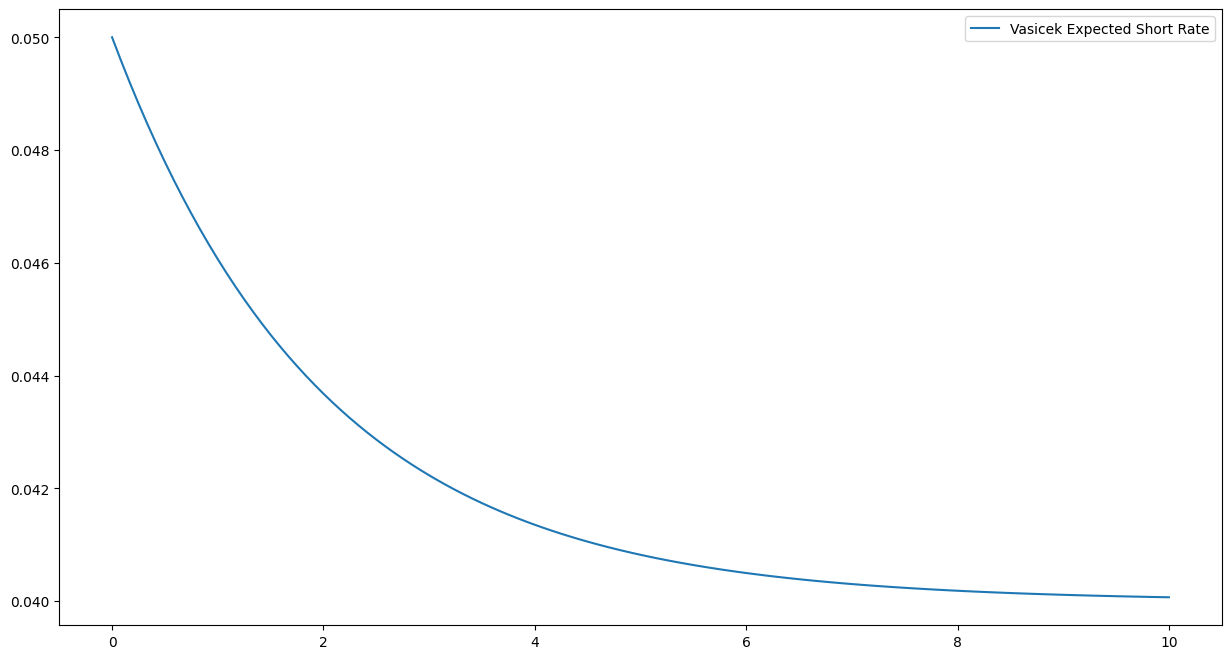

In [1]:
from dynamics import *
import seaborn as sns
import matplotlib.pyplot as plt
#Vasicek model
testDynamic = Vasicek(initial=0.05, mean=0.02, reversion=-0.5, volatility=0.05)
# testDynamic.create_path(stepsize=1/12, duration=15, seed=2023)
plt.figure(figsize=(15,8))
expected = [testDynamic.expectedRate(x) for x in np.arange(0,10*12+1)/12]
sns.lineplot(x=np.arange(0,10*12+1)/12, y=expected, label="Vasicek Expected Short Rate")


<AxesSubplot: >

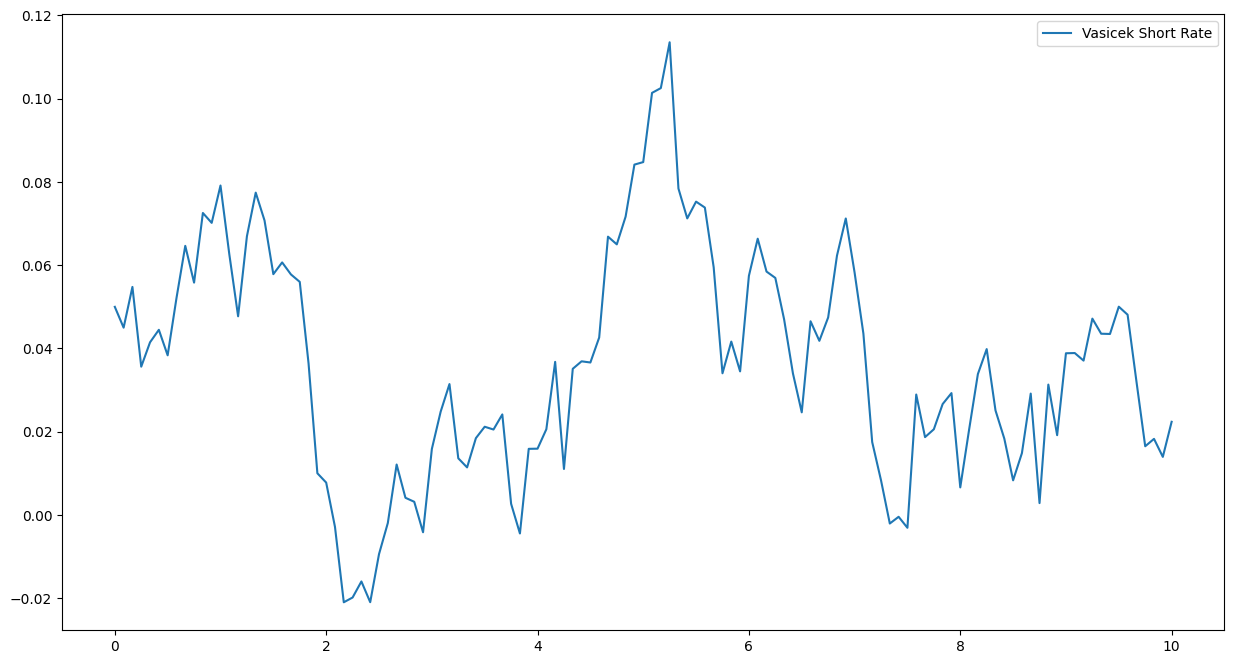

In [2]:
time, rate = testDynamic.create_path(stepsize=1/12, duration=10, seed=1999)
plt.figure(figsize=(15,8))
sns.lineplot(x=time, y=rate, label="Vasicek Short Rate")

<AxesSubplot: >

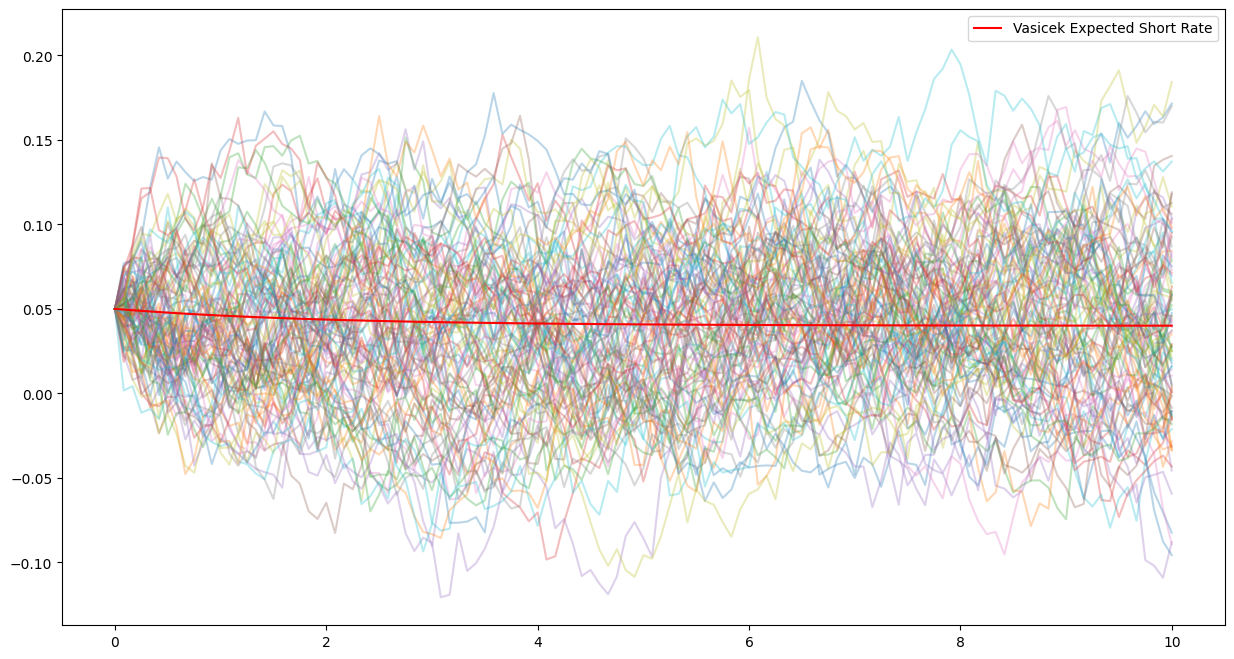

In [3]:
#Some more sims
plt.figure(figsize=(15,8))
for i in range(100):
    time, rate = testDynamic.create_path(stepsize=1/12, duration=10, seed=i)
    sns.lineplot(x=time, y=rate, alpha=0.3)
sns.lineplot(x=time, y=expected, label="Vasicek Expected Short Rate", c='red')

<AxesSubplot: >

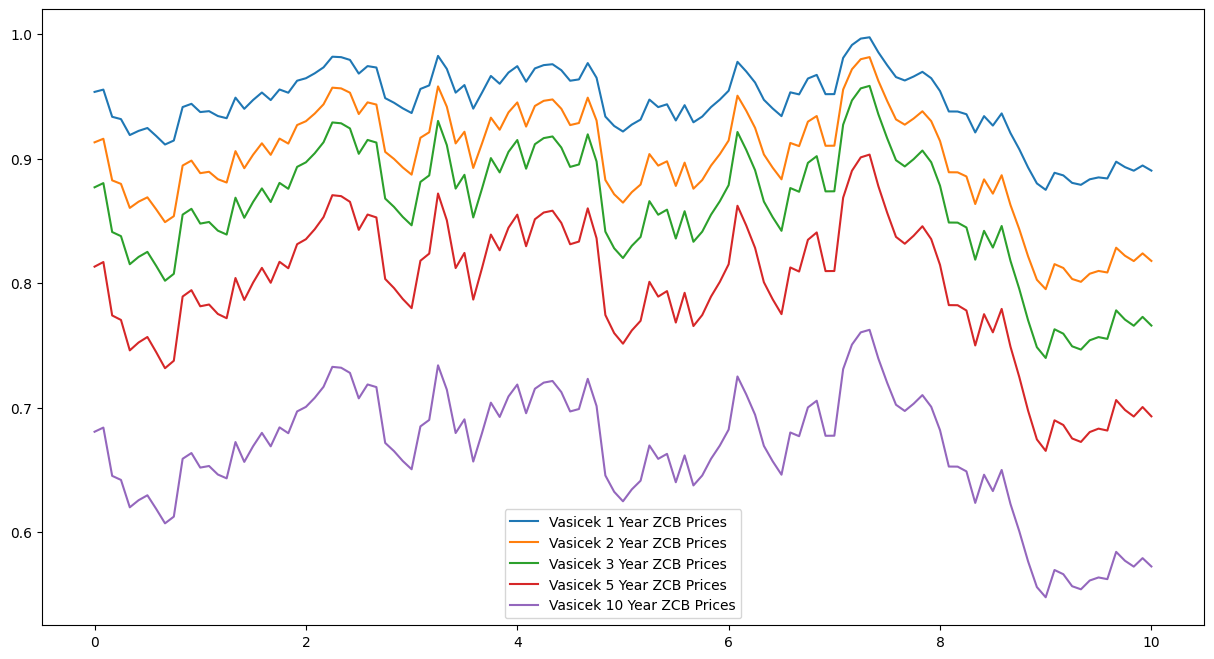

In [4]:
plt.figure(figsize=(15,8))
sns.lineplot(x=time, y=[testDynamic.ZCB(1,x) for x in rate], label = "Vasicek 1 Year ZCB Prices")
sns.lineplot(x=time, y=[testDynamic.ZCB(2,x) for x in rate], label = "Vasicek 2 Year ZCB Prices")
sns.lineplot(x=time, y=[testDynamic.ZCB(3,x) for x in rate], label = "Vasicek 3 Year ZCB Prices")
sns.lineplot(x=time, y=[testDynamic.ZCB(5,x) for x in rate], label = "Vasicek 5 Year ZCB Prices")
sns.lineplot(x=time, y=[testDynamic.ZCB(10,x) for x in rate], label = "Vasicek 10 Year ZCB Prices")

<AxesSubplot: xlabel='Expiry'>

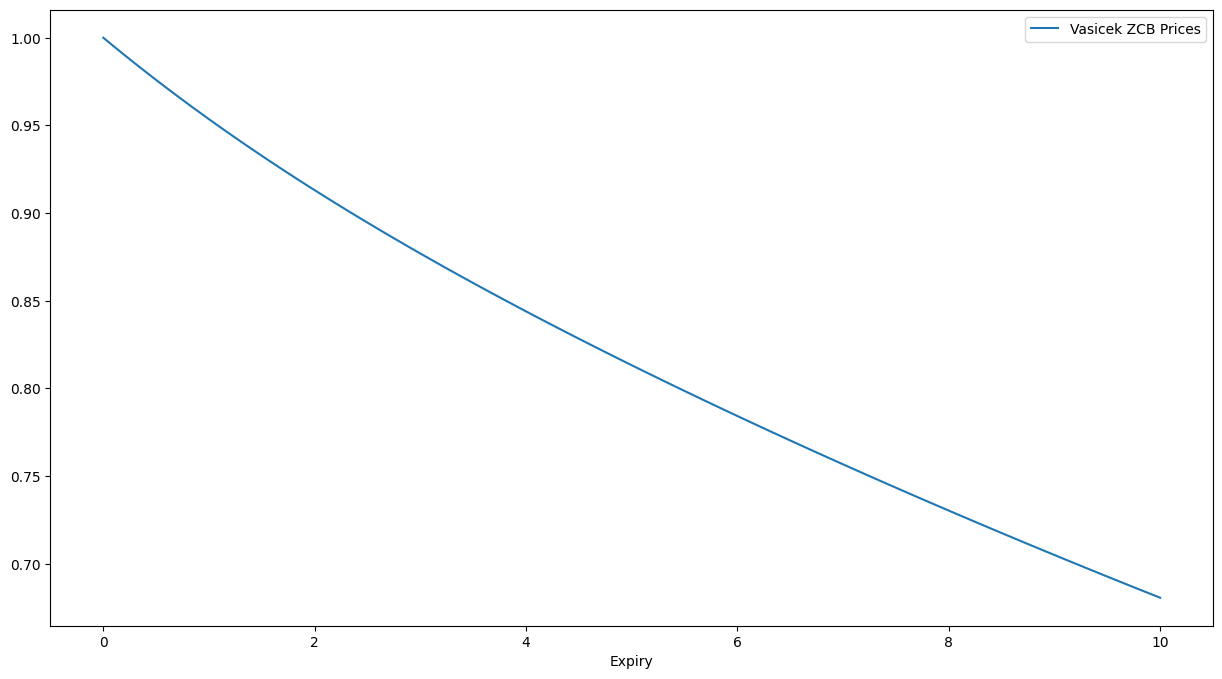

In [5]:
#Zero coupon
plt.figure(figsize=(15,8))
plt.xlabel("Expiry")
sns.lineplot(x=time, y=[testDynamic.ZCB(x,0.05) for x in time], label = "Vasicek ZCB Prices")

# Payer Swap testing
For simplicity the fixed and floating payments are equal <br>
The swap is initiated at t=0 and the last swap is made at t=10

<AxesSubplot: >

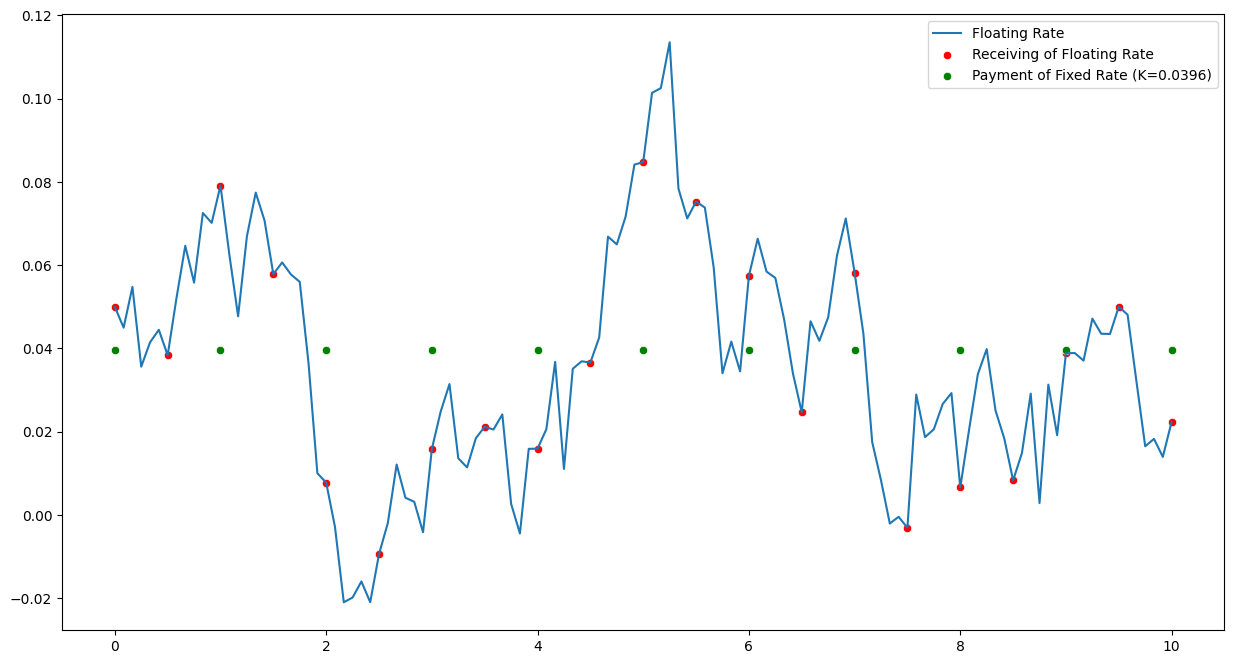

In [6]:
from products import *
from scipy import optimize
fixSchedule = np.arange(0,10+1)
floSchedule = np.arange(0,20+1)/2
time, floatRate = testDynamic.create_path(1/12, 10, 1999)
# (Non analytical way to find par swap rate)
K = parSwapRate(
    fixedSchedule=fixSchedule, 
    floatingSchedule=floSchedule,
    rate=testDynamic.init, 
    model=testDynamic)
plt.figure(figsize=(15,8))
sns.lineplot(x=time, y=floatRate, label='Floating Rate')
sns.scatterplot(x=floSchedule, y=floatRate[0::6], label='Receiving of Floating Rate', c='red')
sns.scatterplot(x=fixSchedule, y=np.repeat(K, len(fixSchedule)), label=f'Payment of Fixed Rate (K={round(K,4)})', c='green')

<AxesSubplot: >

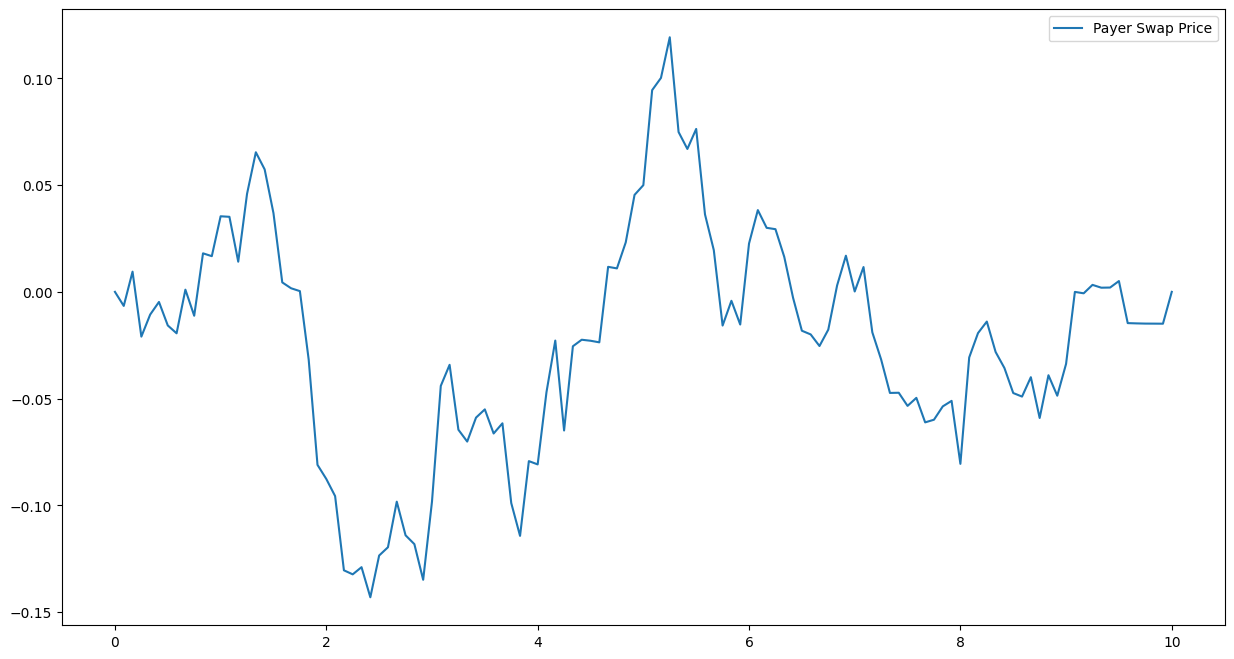

In [7]:
payerSwapPrice = [
payerSwap(
    time=x, 
    fixedSchedule=fixSchedule, 
    floatingSchedule=floSchedule, 
    fixedRate=K, 
    floatingRate=floatRate, 
    floatingTimeStamp=time,
    model=testDynamic
)
for x in time
]

plt.figure(figsize=(15,8))
sns.lineplot(x=time, y=payerSwapPrice, label='Payer Swap Price')

<AxesSubplot: >

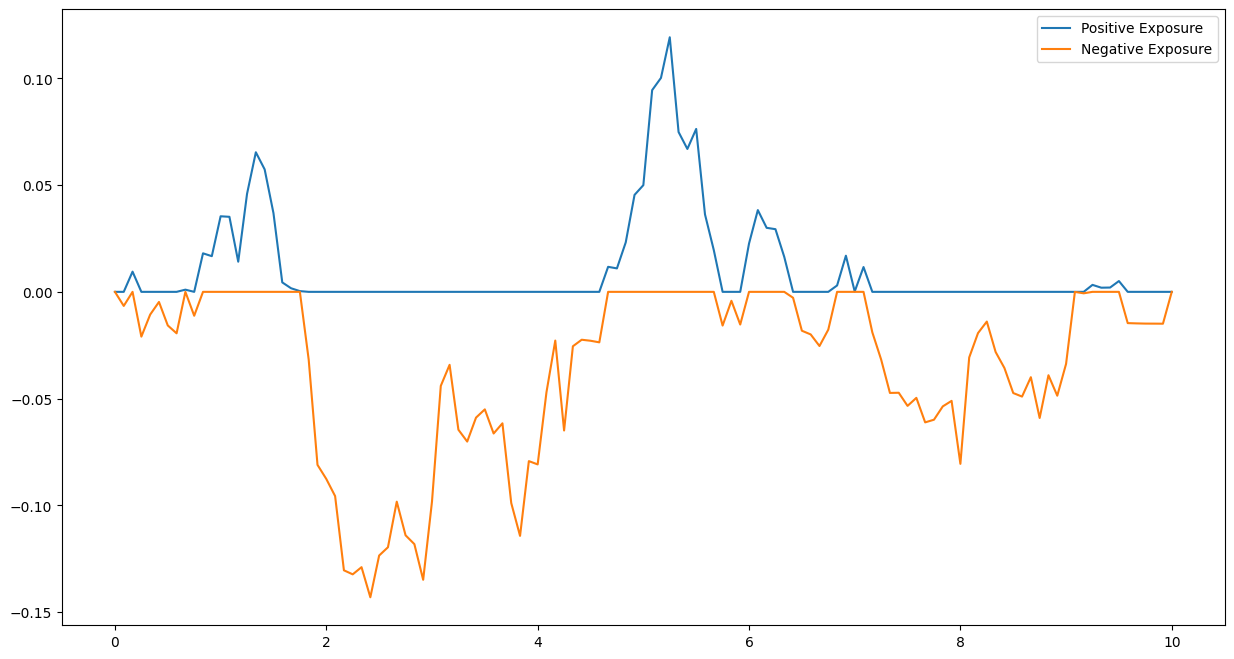

In [8]:
plt.figure(figsize=(15,8))
sns.lineplot(x=time, y=np.maximum(payerSwapPrice,0), label='Positive Exposure')
sns.lineplot(x=time, y=np.minimum(np.array(payerSwapPrice),0), label='Negative Exposure')

In [9]:
for i in range(1,len(floSchedule)):
    print(testDynamic.ZCB(floSchedule[i-1])>testDynamic.ZCB(floSchedule[i]))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [10]:
sims = 15*np.power(10,2)
years=10
dt=1/360
EPE = np.zeros(int(years/dt+1))
ENE = np.zeros(int(years/dt+1))
K = parSwapRate(
    fixedSchedule=fixSchedule, 
    floatingSchedule=floSchedule,
    rate=testDynamic.init, 
    model=testDynamic)
time, floatRate = testDynamic.create_path(stepsize=dt, duration=years, seed=0)
discouting = np.array([testDynamic.ZCB(x) for x in time])
# K = 0.05
for i in range(sims):
    # print(i, end='\r')
    fixSchedule = np.arange(0,10+1)
    floSchedule = np.arange(0,20+1)/2
    time, floatRate = testDynamic.create_path(stepsize=dt, duration=years, seed=i)
    payerSwapPrice=[
    payerSwap(
        time=x, 
        fixedSchedule=fixSchedule, 
        floatingSchedule=floSchedule, 
        fixedRate=K, 
        floatingRate=floatRate, 
        floatingTimeStamp=time,
        model=testDynamic
    )
    for x in time
    ]

    posExposure = np.maximum(payerSwapPrice, 0) #* discouting
    negExposure = np.minimum(payerSwapPrice, 0) #* discouting

    EPE += posExposure
    ENE += negExposure
    print('Process: {:0.2f}'.format(np.round((i+1)/sims*100,2)), end='\r')

# I guess this should be the plotsetup :)

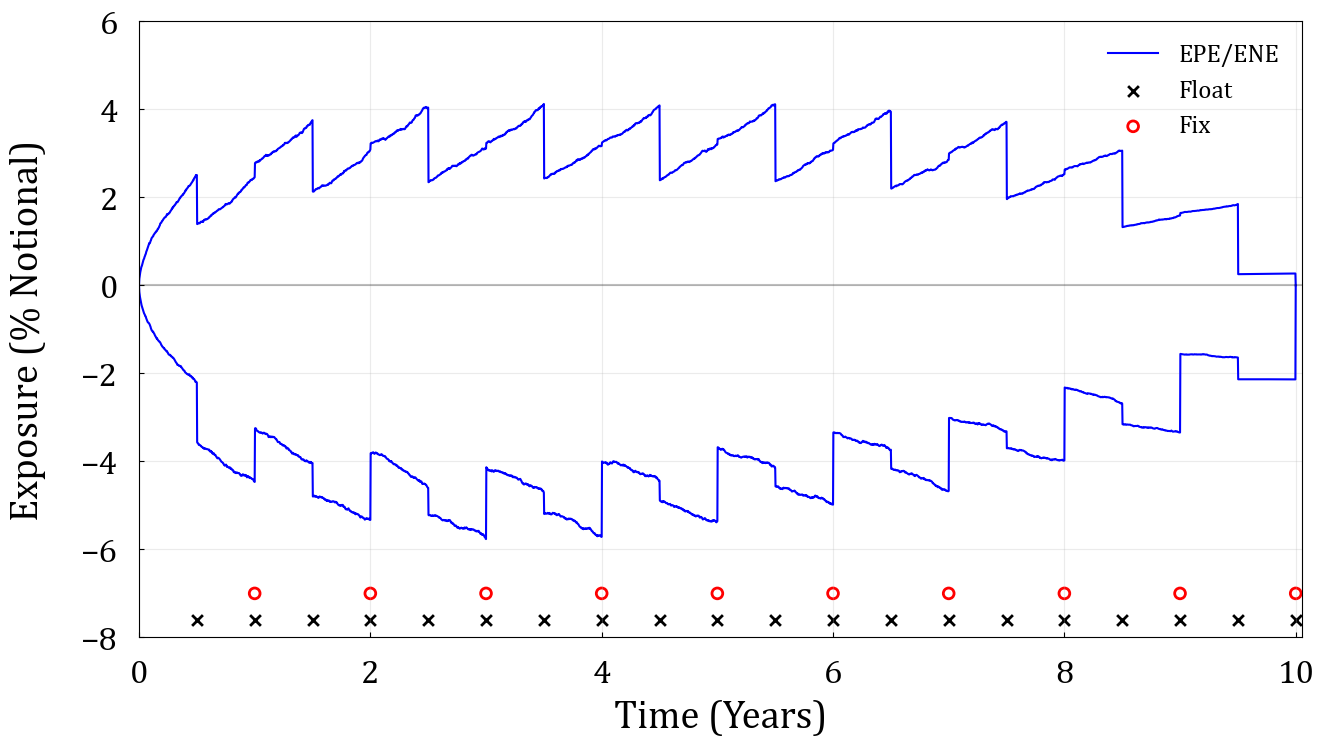

In [140]:
import matplotlib as mpl  
mpl.rc('font',family='Cambria')
float_x = np.arange(0.5,10.5,0.5)
float_y = np.full((len(float_x),), -7.6)
fix_x = np.arange(1,11)
fix_y = np.full(len(fix_x), -7)

fig, ax = plt.subplots()
sns.lineplot(x=time, y=EPE/sims*100, label = 'EPE/ENE', c = 'b')
sns.lineplot(x=time, y=ENE/sims*100, c = 'b')
plt.scatter(x=float_x, y=float_y, label = 'Float', marker = 'x', s = 60, c='black', linewidths=2)
plt.scatter(x=fix_x, y=fix_y, label = 'Fix', marker = 'o', s = 60, facecolors='none', edgecolors='r', linewidths=2)
fig.set_size_inches(15,8)
ax.set_ylim(-8,6)
ax.set_xlim(0,10.05)
ax.set_xlabel('Time (Years)', fontname="Cambria", fontsize = 28)
ax.set_ylabel('Exposure (% Notional)', fontname="Cambria", fontsize = 28)
ax.tick_params(axis='x', direction='in', right = 'True', labelsize = 24, pad = 15)
ax.tick_params(axis='y', direction='in', top = 'True', labelsize = 24, pad = 15)
ax.xaxis.set_label_coords(0.5, -0.1)
ax.yaxis.set_label_coords(-0.08, 0.5)
ax.axhline(y=0, color='k', alpha = 0.25)
plt.grid(alpha = 0.25)
plt.legend(frameon = False, fontsize = 18, loc='upper right')
plt.savefig('Exposure_Plot_10YPayer_Swap', bbox_inches='tight')


## CVA calc with constant intensity

In [12]:
# Default intensity
lc = 0.05
li = 0.01

def survival(intensity, duration):
    return np.exp(-intensity*duration)

Sc = np.array([survival(lc, x) for x in time])

Si = np.array([survival(li, x) for x in time])

dQc=-np.diff(np.insert(Sc, 0, 1))

dQi=-np.diff(np.insert(Si, 0, 1))

LGDc=1
LGDi=1

In [13]:
CVA = -LGDc*sum(Si*dQc*EPE/sims)
DVA = -LGDi*sum(Sc*dQi*ENE/sims)
print('CVA (% Notional):', CVA*100,'DVA (% Notional):', DVA*100)

CVA (% Notional): -1.0047033549901263 DVA (% Notional): 0.2902270324829856


## Swaption testing